#### Latent space clustering

In [1]:
import pickle
from ete3 import Tree
from sys import exit
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import cm  # Import colormap
mpl.rc('font', size=14)
mpl.rc('axes', titlesize='large', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score
import time
import openpyxl  # Required for Excel output

# Read and process the tree:
t = Tree("/home/cdchiang/vae/PF01494/latent_space/simulated_msa/output/random_tree.newick", format=1)
num_leaf = len(t)
t.name = str(num_leaf)

for node in t.traverse('preorder'):
    if node.is_root():
        node.add_feature('anc', [])
        node.add_feature('sumdist', 0)
    else:
        node.add_feature('anc', node.up.anc + [node.up.name])
        node.add_feature('sumdist', node.up.sumdist + node.dist)

# Lists of dist_cutoff values
dist_cutoff_list = np.arange(0.5, 1.3, 0.2)

# Prepare to collect results
all_results = []

# Loop over dist_cutoff values
for dist_cutoff in dist_cutoff_list:
    dist_cutoff = round(dist_cutoff, 1)  # Round for consistent sheet names
    head_node_names = []

    lonely_leaf_count = 0
    for node in t.traverse('preorder'):
        if node.is_leaf() and node.sumdist < dist_cutoff:
            head_node_names.append(node.name)
            lonely_leaf_count += 1
        if (not node.is_leaf()) and node.sumdist > dist_cutoff and node.up.sumdist < dist_cutoff:
            head_node_names.append(node.name)

    cluster_node_names = {}  # Cluster to seq
    leaf2cluster_dict = {}   # Seq to cluster
    cluster_no = 1
    for name in head_node_names:
        cluster_node_names[name] = []
        for leaf in (t & name).iter_leaves():
            cluster_node_names[name].append(leaf.name)
            leaf2cluster_dict[int(leaf.name)] = cluster_no
        cluster_no += 1

    # Sort the seq id in an ascending order and create tree clustering labels
    sorted_leaf_keys = sorted(leaf2cluster_dict.keys())
    tree_labels = [leaf2cluster_dict[item] for item in sorted_leaf_keys]

    # Read latent space representation
    def read_latentspace(file):
        with open(file, 'rb') as file_handle:
            data = pickle.load(file_handle)
        key = data['key']
        mu = data['mu']
        sigma = data['sigma']

        leaf_key2idx = {}
        for i in range(len(key)):
            if int(key[i]) <= 9999:
                leaf_key2idx[int(key[i])] = i

        # Ensure that only keys present in leaf2cluster_dict are considered
        sorted_leaf_idx = [leaf_key2idx[item] for item in sorted_leaf_keys if item in leaf_key2idx]
        leaf_mu = mu[sorted_leaf_idx]

        return leaf_mu

    model_onelayer = "./output/onelayer_n100_weight0.01/latent_space.pkl"
    model_twolayer = "./output/twolayer_n100_500_weight0.01/latent_space.pkl"

    leaf_mu_onelayer = read_latentspace(model_onelayer)
    leaf_mu_twolayer = read_latentspace(model_twolayer)

    # Prepare to collect AMI scores for this dist_cutoff
    results_one = []
    results_two = []

    # Test different numbers of clusters
    cluster_range = range(2, cluster_no+5)  # Adjust the range as needed
    for n_clusters in cluster_range:
        # Ward's method for latent space clustering
        clustering_one = AgglomerativeClustering(n_clusters=n_clusters).fit(leaf_mu_onelayer)
        clustering_two = AgglomerativeClustering(n_clusters=n_clusters).fit(leaf_mu_twolayer)

        # Calculate AMI score
        ami_score_one = adjusted_mutual_info_score(tree_labels, clustering_one.labels_)
        ami_score_two = adjusted_mutual_info_score(tree_labels, clustering_two.labels_)

        # Collect results
        results_one.append({
            'n_clusters': n_clusters,
            'ami_score': ami_score_one
        })
        results_two.append({
            'n_clusters': n_clusters,
            'ami_score': ami_score_two
        })

    # Convert results to DataFrames
    df_one = pd.DataFrame(results_one)
    df_two = pd.DataFrame(results_two)

    # Add a column to identify the model and dist_cutoff
    df_one['model'] = 'onelayer'
    df_two['model'] = 'twolayer'
    df_one['dist_cutoff'] = dist_cutoff
    df_two['dist_cutoff'] = dist_cutoff

    # Combine the results
    combined_df = pd.concat([df_one, df_two], ignore_index=True)

    # Append to all_results
    all_results.append((dist_cutoff, combined_df))

# Write results to Excel with different sheets for each dist_cutoff
output_filename = 'results_latent_space_clustering.xlsx'

with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
    for dist_cutoff, df in all_results:
        sheet_name = f"Cutoff_{dist_cutoff}"
        # Reorder columns for clarity
        df = df[['dist_cutoff', 'model', 'n_clusters', 'ami_score']]
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Results have been written to {output_filename} with separate sheets for each dist_cutoff.")


Results have been written to results_latent_space_clustering.xlsx with separate sheets for each dist_cutoff.


#### Latent space clustering (one layer, n = 100)

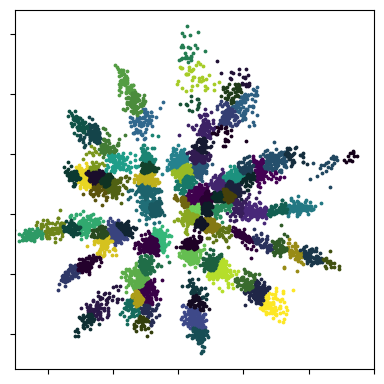

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from matplotlib.colors import to_rgba
from sklearn.cluster import AgglomerativeClustering

mpl.rc('font', size=12)
mpl.rc('axes', titlesize='large', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')

def generate_viridis_colors(base_colors=10, iterations=10):
    """Generates a list of 96 colors by adjusting the intensity of the viridis colormap."""
    base_colormap = plt.cm.viridis(np.linspace(0, 1, base_colors))
    all_colors = []
    
    for iteration in range(iterations):
        factor = 1 - 0.08 * iteration  # reduce intensity on each iteration
        for color in base_colormap:
            adjusted_color = [color[i] * factor for i in range(3)] + [1.]  # Adjust RGB, keep alpha as 1
            all_colors.append(to_rgba(adjusted_color))
            
    return all_colors[:100]  # Ensure only 96 colors are returned

colors = generate_viridis_colors()

def read_latentspace(file):
    """Reads and processes the latent space data."""
    with open(file, 'rb') as file_handle:
        data = pickle.load(file_handle)
    key = data['key']
    mu = data['mu']
    sigma = data['sigma']

    leaf_key2idx = {int(key[i]): i for i in range(len(key)) if int(key[i]) <= 9999}
    sorted_leaf_keys = sorted(leaf_key2idx.keys())
    sorted_leaf_idx = [leaf_key2idx[item] for item in sorted_leaf_keys]
    leaf_mu = mu[sorted_leaf_idx]

    return leaf_mu

# Load latent space data
model_path = "./output/onelayer_n100_weight0.01/latent_space.pkl"
leaf_mu = read_latentspace(model_path)

# Apply Agglomerative Clustering
cluster_no = 100  # Define the number of clusters
clustering = AgglomerativeClustering(n_clusters=cluster_no, linkage='ward')
clustering.fit(leaf_mu)

# Plot the clustered data
fig = plt.figure(figsize=(4, 4))
for cluster_num in range(cluster_no):
    mask = (clustering.labels_ == cluster_num)
    plt.scatter(leaf_mu[mask, 0], leaf_mu[mask, 1], color=colors[cluster_num], s=3, label=f"Cluster {cluster_num}")

# Set plot labels and save
# plt.xlabel(r'$Z_1$')
# plt.ylabel(r'$Z_2$')

# Set x-axis limits
plt.xlim(-5, 6)  

# Set ticks
plt.xticks(np.arange(-4, 7, 2))
plt.yticks(np.arange(-4, 7, 2))

# Hide the tick labels
plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)
plt.tight_layout()

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)  # Optional: Place legend outside plot for clarity
fig.savefig("./output/onelayer_n100_weight0.01/latentspace_clustering.png", dpi=300, format='png')


#### Latent space clustering (two layer, n = 100)

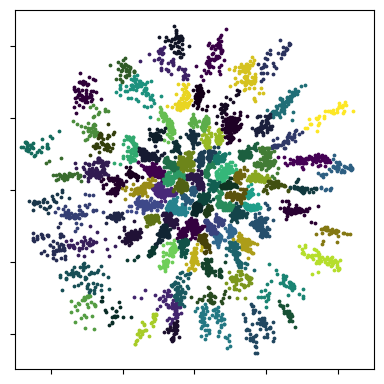

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

from matplotlib.colors import to_rgba
from sklearn.cluster import AgglomerativeClustering

mpl.rc('font', size=12)
mpl.rc('axes', titlesize='large', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')

def generate_viridis_colors(base_colors=10, iterations=10):
    """Generates a list of 96 colors by adjusting the intensity of the viridis colormap."""
    base_colormap = plt.cm.viridis(np.linspace(0, 1, base_colors))
    all_colors = []
    
    for iteration in range(iterations):
        factor = 1 - 0.08 * iteration  # reduce intensity on each iteration
        for color in base_colormap:
            adjusted_color = [color[i] * factor for i in range(3)] + [1.]  # Adjust RGB, keep alpha as 1
            all_colors.append(to_rgba(adjusted_color))
            
    return all_colors[:100]  # Ensure only 96 colors are returned

colors = generate_viridis_colors()

def read_latentspace(file):
    """Reads and processes the latent space data."""
    with open(file, 'rb') as file_handle:
        data = pickle.load(file_handle)
    key = data['key']
    mu = data['mu']
    sigma = data['sigma']

    leaf_key2idx = {int(key[i]): i for i in range(len(key)) if int(key[i]) <= 9999}
    sorted_leaf_keys = sorted(leaf_key2idx.keys())
    sorted_leaf_idx = [leaf_key2idx[item] for item in sorted_leaf_keys]
    leaf_mu = mu[sorted_leaf_idx]

    return leaf_mu

# Load latent space data
model_path = "./output/twolayer_n100_500_weight0.01/latent_space.pkl"
leaf_mu = read_latentspace(model_path)

# Apply Agglomerative Clustering
cluster_no = 100  # Define the number of clusters
clustering = AgglomerativeClustering(n_clusters=cluster_no, linkage='ward')
clustering.fit(leaf_mu)

# Plot the clustered data
fig = plt.figure(figsize=(4, 4))
for cluster_num in range(cluster_no):
    mask = (clustering.labels_ == cluster_num)
    plt.scatter(leaf_mu[mask, 0], leaf_mu[mask, 1], color=colors[cluster_num], s=3, label=f"Cluster {cluster_num}")

# Set plot labels and save
# plt.xlabel(r'$Z_1$')
# plt.ylabel(r'$Z_2$')
plt.xlim(-5, 5)  # Set x-axis limits
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 5, 2))

# Hide the tick labels
plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

plt.tight_layout()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)  # Optional: Place legend outside plot for clarity
fig.savefig("./output/twolayer_n100_500_weight0.01/latentspace_clustering.png", dpi=300, format='png')